In [40]:
from pathlib import Path
import pandas as pd
import numpy as np
import time
import math
from matplotlib import pyplot as plt
import hvplot.pandas
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow_addons.metrics import RSquare
from keras import models, layers

# Part 1. Explotary Data Analysis and Feature Engineering / Data Transformation 
# Part 2. Model Building ( Model Experiments)
# Part 3. Accuracy for top 100 products (by revenue) predicted vs actual

### Part 1. Explotary Data Analysis and Feature Engineering / Data Transformation 


In [ ]:
positions = pd.read_csv('data/positions.csv')
product_blocks = pd.read_csv('data/product_blocks.csv')
products = pd.read_csv('data/products.csv')
sales_stock = pd.read_csv('data/sales_stock.csv')


In [9]:
#Some statistics of the datasets

num_positions=positions['position'].nunique()
num_days=sales_stock['date_number'].nunique()
num_products=products['product_id'].nunique()
num_blocks=product_blocks['block_id'].nunique()
num_family=products['family_id'].nunique()
num_subfamily=products['subfamily_id'].nunique()

print(f'Number of positions :{num_positions}')
print(f'Number of products :{num_products}')
print(f'Number of blocks :{num_blocks}')
print(f'Number of family :{num_family}')
print(f'Number of subfamily :{num_subfamily}')
print(f'Number of days :{num_days}')

Number of positions :954
Number of products :15238
Number of blocks :2776
Number of family :84
Number of subfamily :288
Number of days :92


In [10]:
#Position column indicates that position for a specific product changes througout the given day 
#position refers to the position on the website

positions.loc[ (positions['product_id'] == 4450020) & ( positions['date_number'] == 2 ), :]

positions.head()

,date_number,product_id,category_id,position
0,0,4450020,4461548,17
1,0,42147334,4461548,4
2,0,81131830,4461548,35
3,0,84035833,4461548,38
4,0,125252584,4461548,39


In [11]:
# pos_count: number of categories where each product appears
pos_count=pd.DataFrame(positions.groupby(['date_number','product_id']).count()['position']).reset_index()
pos_count.head()

,date_number,product_id,position
0,0,310130,3
1,0,1178388,1
2,0,1561460,3
3,0,1874414,6
4,0,2094841,4


In [12]:
#pos_min: minimum (best) position of each product

pos_min=pd.DataFrame(positions.groupby(['date_number','product_id']).min()['position']
).reset_index()

pos_min.head() 

,date_number,product_id,position
0,0,310130,3
1,0,1178388,19
2,0,1561460,3
3,0,1874414,12
4,0,2094841,48


In [13]:
# pos_max: maximum (worst) position of each product

pos_max=pd.DataFrame(positions.groupby(['date_number','product_id']).max()['position']
).reset_index()

pos_max.head()

,date_number,product_id,position
0,0,310130,80
1,0,1178388,19
2,0,1561460,38
3,0,1874414,190
4,0,2094841,204


In [14]:
# pos_mean: mean position of each product
pos_mean=pd.DataFrame(positions.groupby(['date_number','product_id']).mean()['position']).reset_index()
                                      
pos_mean.head()   

,date_number,product_id,position
0,0,310130,54.333333
1,0,1178388,19.000000
2,0,1561460,20.000000
3,0,1874414,64.666667
4,0,2094841,130.250000


In [15]:
# Adding pos_count, pos_min, pos_max and pos_mean to the positions dataset
positions_final=pos_count.copy().rename(columns={"position": "pos_count"})
positions_final['pos_min']=pos_min['position']
positions_final['pos_max']=pos_max['position']
positions_final['pos_mean']=pos_mean['position']

positions_final.head()

,date_number,product_id,pos_count,pos_min,pos_max,pos_mean
0,0,310130,3,3,80,54.333333
1,0,1178388,1,19,19,19.000000
2,0,1561460,3,3,38,20.000000
3,0,1874414,6,12,190,64.666667
4,0,2094841,4,48,204,130.250000


In [16]:
# Each block contains multiple products 

product_blocks.loc[ (product_blocks['block_id'] == 0) , :].sort_values('block_id')

,product_id,block_id
0,612967398,0
1,296892108,0
2,139541214,0
3,963923934,0
4,938230141,0
5,172045154,0
6,663552768,0


In [17]:
# Adding number of items in a block as new feature to the block data

blocks_aux = product_blocks.groupby( 'block_id' ).count()['product_id'].reset_index()
blocks_aux.rename(columns={'product_id': 'num_items'}, inplace=True)
blocks_final = pd.merge(product_blocks, blocks_aux, on='block_id')
blocks_final.head() 

,product_id,block_id,num_items
0,612967398,0,7
1,296892108,0,7
2,139541214,0,7
3,963923934,0,7
4,938230141,0,7


In [18]:
# Removing color_id and size_id columns and aggregating sales only by product_id
stay_columns=['date_number','product_id']

sales_final = sales_stock.groupby(stay_columns).agg( { 'sales': 'sum', 'stock': 'sum' } ).reset_index()
sales_final.head()

,date_number,product_id,sales,stock
0,0,310130,11,461
1,0,1178388,0,60
2,0,1561460,7,791
3,0,1874414,4,281
4,0,2436420,0,245


In [19]:
# Merging the all transformed datasets 

df_final=pd.merge(sales_final, positions_final, on=['date_number','product_id'], how='inner')\
.merge(blocks_final, on='product_id', how='inner' ).merge(products, on='product_id', how='inner' )
df_final.head()


,date_number,product_id,sales,stock,pos_count,pos_min,pos_max,pos_mean,block_id,num_items,family_id,subfamily_id,price
0,0,310130,11,461,3,3,80,54.333333,1726,8,679611953,533441312,12.95
1,1,310130,13,437,3,2,3,2.666667,1726,8,679611953,533441312,12.95
2,2,310130,14,435,3,2,8,6.000000,1726,8,679611953,533441312,12.95
3,3,310130,15,410,3,4,8,6.666667,1726,8,679611953,533441312,12.95
4,4,310130,17,538,3,4,8,6.666667,1726,8,679611953,533441312,12.95


In [20]:
# Using ML , clustering day 84 (last day in training in the dataset)

df_84_cluster_data = df_final.loc[ df_final['date_number'] == 84, ['product_id', 'num_items', 'stock', 'price', 'pos_count'] ].reset_index(drop=True)
df_84_cluster_data.head()


,product_id,num_items,stock,price,pos_count
0,310130,8,341,12.95,1
1,1561460,9,448,29.95,3
2,1874414,3,246,25.95,6
3,2644529,4,201,7.95,2
4,3176725,9,331,29.95,3


In [21]:
#Selecting only non-numerical features for clustering 

cluster_train_data_84 = df_84_cluster_data[ [ 'num_items', 'stock', 'price', 'pos_count' ] ]
cluster_train_data_84.head()


,num_items,stock,price,pos_count
0,8,341,12.95,1
1,9,448,29.95,3
2,3,246,25.95,6
3,4,201,7.95,2
4,9,331,29.95,3


In [22]:
# Normalizing the data using standard scaler

scaler = StandardScaler()
scaled_data_84 = scaler.fit_transform(cluster_train_data_84)
scaled_data_84[:5]


array([[ 0.39713525,  0.17310426, -0.77149081, -1.05065654],
       [ 0.8048482 ,  0.44042027,  0.28837576,  0.27464307],
       [-1.64142951, -0.06423237,  0.03899539,  2.26259248],
       [-1.23371656, -0.17665499, -1.08321627, -0.38800674],
       [ 0.8048482 ,  0.14812146,  0.28837576,  0.27464307]])

In [23]:
# Using PCA for the cluster to get more clean cluster than K-means
pca = PCA(n_components=2)
cluster_train_data_84_pca = pca.fit_transform(scaled_data_84)
variance_ratio = pca.explained_variance_ratio_
print( f"Explained variance ratio with 2 principal components: {variance_ratio}" )

Explained variance ratio with 2 principal components: [0.30170725 0.25002121]


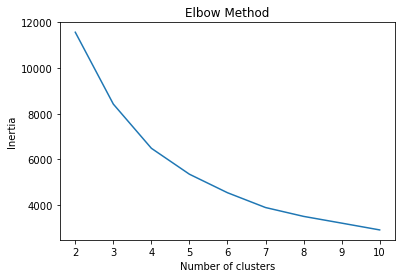

In [24]:
# Finding k means and plotting the result

inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit( cluster_train_data_84_pca )
    inertia.append(kmeans.inertia_)
    
plt.plot(range(2, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [25]:
# Adding the cluster column to the df_84_cluster_data

kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit( pd.DataFrame(cluster_train_data_84_pca) )

labels = kmeans.labels_
df_84_cluster_data['cluster_labels'] = labels
df_84_cluster_data['principal_component_1'] = cluster_train_data_84_pca[:, 0]
df_84_cluster_data['principal_component_2'] = cluster_train_data_84_pca[:, 1]
df_84_cluster_data.head()


,product_id,num_items,stock,price,pos_count,cluster_labels,principal_component_1,principal_component_2
0,310130,8,341,12.95,1,3,0.025018,-0.161967
1,1561460,9,448,29.95,3,3,0.092808,-0.757716
2,1874414,3,246,25.95,6,1,1.280072,1.035497
3,2644529,4,201,7.95,2,1,0.564468,1.178173
4,3176725,9,331,29.95,3,3,-0.057877,-0.797549


Text(0, 0.5, 'Principal component 2')

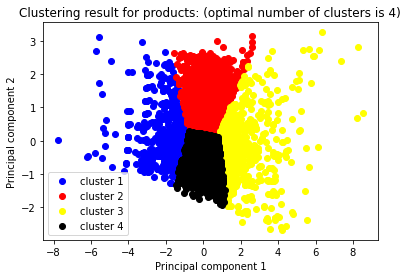

In [26]:
# Plot the clusters
cluster_1 = df_84_cluster_data.loc[ df_84_cluster_data['cluster_labels'] == 0, [ 'principal_component_1', 'principal_component_2' ] ]
cluster_2 = df_84_cluster_data.loc[ df_84_cluster_data['cluster_labels'] == 1, [ 'principal_component_1', 'principal_component_2' ] ]
cluster_3 = df_84_cluster_data.loc[ df_84_cluster_data['cluster_labels'] == 2, [ 'principal_component_1', 'principal_component_2' ] ]
cluster_4 = df_84_cluster_data.loc[ df_84_cluster_data['cluster_labels'] == 3, [ 'principal_component_1', 'principal_component_2' ] ]

plt.scatter( cluster_1['principal_component_1'], cluster_1['principal_component_2'], color='blue' )
plt.scatter( cluster_2['principal_component_1'], cluster_2['principal_component_2'], color='red' )
plt.scatter( cluster_3['principal_component_1'], cluster_3['principal_component_2'], color='yellow' )
plt.scatter( cluster_4['principal_component_1'], cluster_4['principal_component_2'], color='black' )

plt.legend(('cluster 1', 'cluster 2', 'cluster 3', 'cluster 4'))

plt.title('Clustering result for products: (optimal number of clusters is 4)')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')


In [27]:
# Adding cluster column to the original data as a new feature

df_final=pd.merge(df_final, df_84_cluster_data[['product_id', 'cluster_labels']], on='product_id', how="inner")
df_final

,date_number,product_id,sales,stock,pos_count,pos_min,pos_max,pos_mean,block_id,num_items,family_id,subfamily_id,price,cluster_labels
0,0,310130,11,461,3,3,80,54.333333,1726,8,679611953,533441312,12.95,3
1,1,310130,13,437,3,2,3,2.666667,1726,8,679611953,533441312,12.95,3
2,2,310130,14,435,3,2,8,6.000000,1726,8,679611953,533441312,12.95,3
3,3,310130,15,410,3,4,8,6.666667,1726,8,679611953,533441312,12.95,3
4,4,310130,17,538,3,4,8,6.666667,1726,8,679611953,533441312,12.95,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539144,90,922173956,0,477,3,8,701,382.333333,925,2,396066037,756330372,19.95,1
539145,91,922173956,4,480,3,8,714,389.000000,925,2,396066037,756330372,19.95,1
539146,84,846517852,0,1,1,34,34,34.000000,513,7,512899033,29433772,4.95,3
539147,85,846517852,0,1,1,35,35,35.000000,513,7,512899033,29433772,4.95,3


### Part 2. Model Building ( Model Experiments)

In [28]:
# Splitting train and test data ( last 7 days data is used as test data)

df_train = df_final.loc[ df_final['date_number'] < 85, : ]
df_test = df_final.loc[ df_final['date_number'] >= 85, : ]

X_train = df_train.drop(['sales'], axis=1)
y_train = df_train.loc[:,'sales']

X_test = df_test.drop(['sales'], axis=1)
y_test = df_test.loc[:,'sales']

In [29]:
# Model training with Random Forest

rf = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [30]:
# Use the random forest's predict method on the test data
predictions = rf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


In [31]:
# Calculate the R^2 score
r2_score_value = r2_score(y_test, predictions)

# Print out the R^2 score
print('R-squared score:', r2_score_value)

R-squared score: 0.4085792891638239


In [149]:
# Model training with XGBoost (experiment1: n_estimators=100, max_depth=7)

model_xgb = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [150]:
# Use the XGBoost's predict method on the test data
predictions_xgb = model_xgb.predict(X_test)

In [151]:
# Calculate the R^2 score
r2_score_value = r2_score(y_test, predictions_xgb)

# Print out the R^2 score for the XGBoost model
print('R-squared score:', r2_score_value)

R-squared score: 0.48083822157779954


In [152]:
# Model training with XGBoost (experiment2: n_estimators=200, max_depth=10)

model_xgb_2 = XGBRegressor(n_estimators=200, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

model_xgb_2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [154]:
# Use the XGBoost's predict method on the test data
predictions_xgb_2 = model_xgb_2.predict(X_test)

In [155]:
# Calculate the R^2 score
r2_score_value_2 = r2_score(y_test, predictions_xgb_2)

# Print out the R^2 score for the XGBoost model
print('R-squared score:', r2_score_value_2)

R-squared score: 0.5914151175263138


In [32]:
# Model training with XGBoost (experiment 3: n_estimators=300, max_depth=10)

model_xgb_3 = XGBRegressor(n_estimators=300, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

model_xgb_3.fit(X_train, y_train)

# Use the XGBoost's predict method on the test data
predictions_xgb_3 = model_xgb_3.predict(X_test)

# Calculate the R^2 score
r2_score_value_3 = r2_score(y_test, predictions_xgb_3)

# Print out the R^2 score for the XGBoost model
print('R-squared score:', r2_score_value_3)

R-squared score: 0.6002969491653545


<BarContainer object of 13 artists>

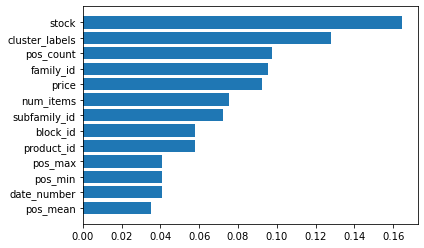

In [51]:
# Checking the feature imporance of the XG boost 3rd experiment
feature_names = [ 'date_number', 'product_id', 'stock', 'pos_count', 'pos_min',
       'pos_max', 'pos_mean', 'block_id', 'num_items', 'family_id',
       'subfamily_id', 'price', 'cluster_labels' ]
model_xgb_3.feature_importances_

XGB_4_feat_imp = pd.DataFrame( model_xgb_3.feature_importances_, columns=['feature importances'] )
XGB_4_feat_imp['features'] = feature_names
XGB_4_feat_imp.sort_values('feature importances', ascending=True, inplace=True)

plt.barh(XGB_4_feat_imp['features'], XGB_4_feat_imp['feature importances'])

In [37]:
#Removing the 'sales', 'pos_min', 'pos_max', 'pos_mean' as they showed least feature importance

X_train_2 = df_train.drop(['sales', 'pos_min', 'pos_max', 'pos_mean'], axis=1)
y_train_2 = df_train.loc[:,'sales']

X_test_2 = df_test.drop(['sales', 'pos_min', 'pos_max', 'pos_mean'], axis=1)
y_test_2 = df_test.loc[:,'sales']

In [38]:
# Model building with XG boost with fewer features

model_xgb_4 = XGBRegressor(n_estimators=300, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

model_xgb_4.fit(X_train_2, y_train_2)

# Use the XGBoost's predict method on the test data
predictions_xgb_4 = model_xgb_4.predict(X_test_2)

# Calculate the R^2 score
r2_score_value_4 = r2_score(y_test_2, predictions_xgb_4)

# Print out the R^2 score for the XGBoost model
print('R-squared score :', r2_score_value_4)

R-squared score: 0.6110690009488817


In [52]:
# Model building with deep learning
model = models.Sequential()

model.add(layers.Dense(20, activation='relu', input_shape=[X_train_2.shape[1]]))
model.add(layers.Dense(30, activation='relu'))

# output layer
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=[RSquare()])
history = model.fit(X_train_2, y_train_2, validation_split=0.1, epochs=10)

predictions_dl = model.predict(X_test_2)

# Calculate the R^2 score
r2_score_value_dl = r2_score(y_test_2, predictions_dl)

# Print out the R^2 score for the XGBoost model
print('R-squared score:', r2_score_value_dl)

Epoch 1/10
13696/13696 [==============================] - 35s 2ms/step - loss: 1767490715648.0000 - r_square: -11756588032.0000 - val_loss: 217.3642 - val_r_square: -0.0504
Epoch 2/10
13696/13696 [==============================] - 31s 2ms/step - loss: 150.3618 - r_square: -1.3936e-04 - val_loss: 216.4183 - val_r_square: -0.0459
Epoch 3/10
13696/13696 [==============================] - 29s 2ms/step - loss: 150.3588 - r_square: -1.2040e-04 - val_loss: 215.1475 - val_r_square: -0.0397
Epoch 4/10
13696/13696 [==============================] - 30s 2ms/step - loss: 150.3578 - r_square: -1.1337e-04 - val_loss: 215.7763 - val_r_square: -0.0428
Epoch 5/10
13696/13696 [==============================] - 29s 2ms/step - loss: 150.3617 - r_square: -1.3888e-04 - val_loss: 216.2170 - val_r_square: -0.0449
Epoch 6/10
13696/13696 [==============================] - 30s 2ms/step - loss: 150.3591 - r_square: -1.2374e-04 - val_loss: 215.1849 - val_r_square: -0.0399
Epoch 7/10
13696/13696 [==================

### Part 3. Accuracy for top 100 products (by revenue) predicted vs actual

In [58]:


# Adding revenue columns to both train and test data 

X_test['sales_prediction_xgb_3'] = predictions_xgb_3
X_test['product_revenue_xgb_3'] = X_test['sales_prediction_xgb_3'] * X_test['price']

X_test['actual_sales'] = y_test
X_test['actual_revenue'] = X_test['actual_sales'] * X_test['price']

X_test.head()

,date_number,product_id,stock,pos_count,pos_min,pos_max,pos_mean,block_id,num_items,family_id,subfamily_id,price,cluster_labels,sales_prediction_xgb_3,product_revenue_xgb_3,actual_sales,actual_revenue
84,85,310130,334,1,49,49,49.0,1726,8,679611953,533441312,12.95,3,4.210908,54.531264,3,38.85
85,86,310130,337,1,48,48,48.0,1726,8,679611953,533441312,12.95,3,4.585373,59.380586,2,25.90
86,87,310130,332,1,48,48,48.0,1726,8,679611953,533441312,12.95,3,4.845256,62.746069,3,38.85
87,88,310130,331,1,47,47,47.0,1726,8,679611953,533441312,12.95,3,4.845256,62.746069,2,25.90
88,89,310130,323,1,48,48,48.0,1726,8,679611953,533441312,12.95,3,4.724742,61.185408,4,51.80


In [63]:
# Defining a function that calcutes the overlapping percentage for top 100 products predicted vs actual

def best_performing_products_predicted( X_test, date_number_value ):
    
    product_perf_85 = X_test.loc[ X_test['date_number'] == date_number_value, : ].sort_values('product_revenue_xgb_3', ascending=False).reset_index(drop=True)
    product_perf_85 = product_perf_85.head(100)
    product_perf_85.head()
    
    product_perf_actual_85 = X_test.loc[ X_test['date_number'] == date_number_value, : ].sort_values('actual_revenue', ascending=False).reset_index(drop=True)
    product_perf_actual_85 = product_perf_actual_85.head(100)
    product_perf_actual_85.head()
    
    predict_products = list(product_perf_85['product_id'].values)
    actual_products = list(product_perf_actual_85['product_id'].values)
    
    common_products = set(predict_products).intersection(actual_products)
    portion_of_products_predicted = len(common_products) / 100
    
    return portion_of_products_predicted


In [64]:
# Day 85

prediction_rate_best_performing_products_day_85 = best_performing_products_predicted( X_test, date_number_value=85 )

print(f"Correctly predicted best performing products portion for day {85} is {prediction_rate_best_performing_products_day_85}.")


Correctly predicted best performing products portion for day 85 is 0.66.


In [66]:
# Day 86

prediction_rate_best_performing_products_day_86 = best_performing_products_predicted( X_test, date_number_value=86 )

print(f"Correctly predicted best performing products portion for day {86} is {prediction_rate_best_performing_products_day_86}.")


Correctly predicted best performing products portion for day 86 is 0.61.


In [67]:
# Day 87

prediction_rate_best_performing_products_day_87 = best_performing_products_predicted( X_test, date_number_value=87 )

print(f"Correctly predicted best performing products portion for day {87} is {prediction_rate_best_performing_products_day_87}.")


Correctly predicted best performing products portion for day 87 is 0.5.


In [69]:
# Day 88

prediction_rate_best_performing_products_day_88 = best_performing_products_predicted( X_test, date_number_value=88 )

print(f"Correctly predicted best performing products portion for day {88} is {prediction_rate_best_performing_products_day_88}.")


Correctly predicted best performing products portion for day 88 is 0.49.


In [70]:
# Day 89

prediction_rate_best_performing_products_day_89 = best_performing_products_predicted( X_test, date_number_value=89 )

print(f"Correctly predicted best performing products portion for day {89} is {prediction_rate_best_performing_products_day_89}.")


Correctly predicted best performing products portion for day 89 is 0.45.


In [71]:
# Day 90

prediction_rate_best_performing_products_day_90 = best_performing_products_predicted( X_test, date_number_value=90 )

print(f"Correctly predicted best performing products portion for day {90} is {prediction_rate_best_performing_products_day_90}.")


Correctly predicted best performing products portion for day 90 is 0.45.


In [72]:
# Day 91

prediction_rate_best_performing_products_day_91 = best_performing_products_predicted( X_test, date_number_value=91 )

print(f"Correctly predicted best performing products portion for day {91} is {prediction_rate_best_performing_products_day_91}.")


Correctly predicted best performing products portion for day 91 is 0.51.
